In [1]:
from experiment_func_2 import *
import matplotlib.pyplot as plt
import cv2
import skimage 
import numpy as np
from TokenCut.datasets import Dataset, ImageDataset, bbox_iou 
%matplotlib inline

In [2]:
dataset = Dataset("VOC07", "train", True)

Nb images discarded 735


In [3]:
patch_size = 8
model = get_model('dino_base', patch_size=patch_size, device='cuda')

Pre-trained weights founde at dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth and loaded with msg : <All keys matched successfully>


In [4]:
dataloader = dataset.dataloader
inp = dataloader[203]
im_name = dataset.get_image_name(inp[1])
gt_bbxs, gt_cls = dataset.extract_gt(inp[1], im_name)
print(im_name)
print(gt_bbxs)

000887.jpg
[[ 24  48 473 247]]


In [7]:
len(dataset.dataloader)

2501

input cls shape : torch.Size([1, 768])
cls shape : torch.Size([768])
feats shaep : torch.Size([2520, 768])
sim shape : torch.Size([1, 2520])
torch.Size([2520])
Tokencut feats shape : torch.Size([2520, 768])
lost seed : 1790
TokenCut seed : 1660
plot seed
[[ 96  56 464 224]
 [  8 144 120 168]]
plot seed


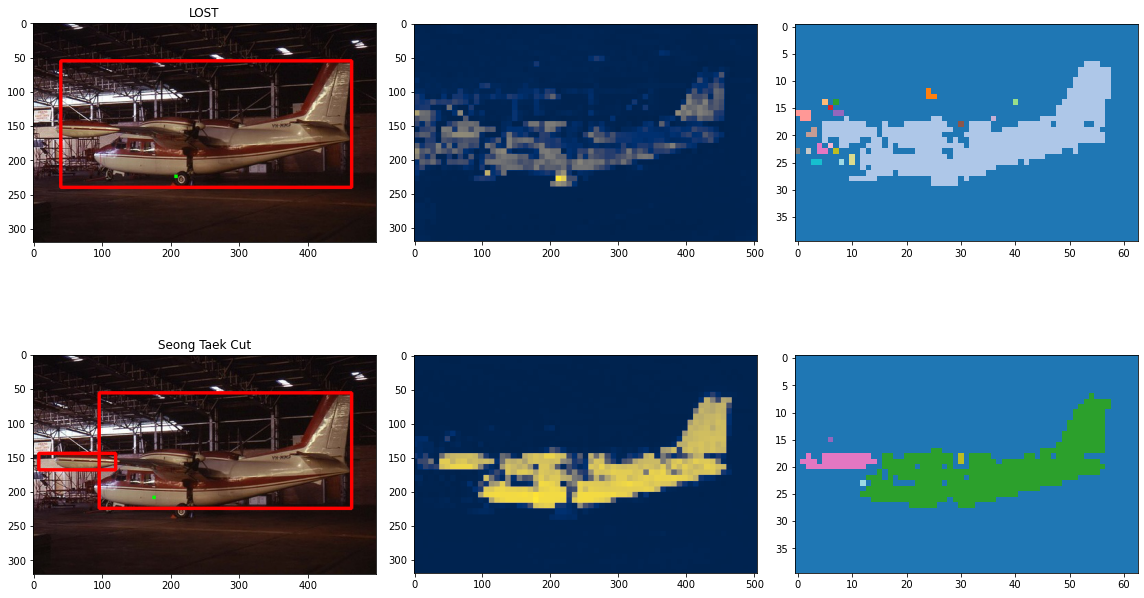

In [5]:
img_path = f'/monet/TokenCut/datasets/VOC2007/VOCdevkit/VOC2007/JPEGImages/{im_name}'
scikit_img = load_image(img_path=img_path)
# scikit_img = skimage.transform.resize(scikit_img, (480,480))
plt.figure(figsize=(16,10))
t_la, l_la, preds = lost_tokencut(img_path=img_path,
                                    model = model,
                                    patch_size=patch_size,
                                    feature='k',
                                    depth=-1,
                                    cmap='cividis',
                                    plot_seed=True,
                                    tau=0.2
                                    )

In [192]:
preds[0]

array([ 96,  56, 464, 224])

In [191]:
ious = bbox_iou(torch.from_numpy(preds[0]), torch.from_numpy(gt_bbxs))
print(ious)

tensor([0.6919])


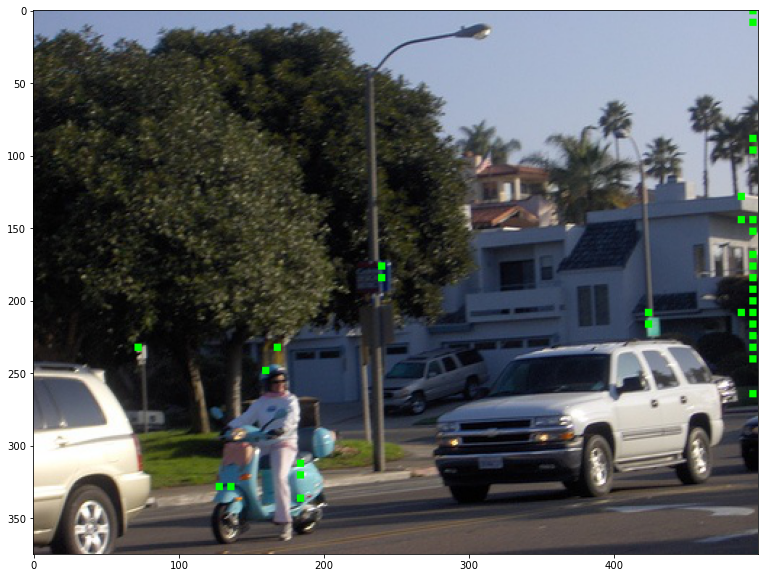

In [54]:
seed_image = scikit_img.copy()
img = img_ImageDataset(img_path=img_path)
input_image, w_featmap, h_featmap = img_prop(img=img, patch_size=patch_size)
cls_, output_, q_ , k_, v_ = get_feature(model=model, input_img=input_image )
scales = [patch_size,patch_size]
cls_ = cls_[:-1]
cls = q_[-1][:, 0 , :]
feat = k_[-1][:, 1:, :]
sim = F.cosine_similarity(cls, feat, dim=-1)
value = torch.sort(sim, descending=True)[0][0]

pos_value = value[torch.where(value > 0 )[0]]
mean_pos_value = torch.mean(pos_value)
max_len = len(torch.where(value > mean_pos_value)[0])
where = torch.sort(sim, descending=True)[1][0, :max_len]

for tmp_seed in where:
    s_ = np.unravel_index(tmp_seed.cpu().numpy(), (w_featmap, h_featmap))
    size_ = np.asarray(scales) /2
    cv2.rectangle(
    seed_image,
        (int(s_[1] * scales[1] - (size_[1] / 2)), int(s_[0] * scales[0] - (size_[0] / 2))),
        (int(s_[1] * scales[1] + (size_[1] / 2)), int(s_[0] * scales[0] + (size_[0] / 2))),
        (0, 255 ,0), -1, 
    )
plt.figure(figsize=(16,10))
plt.imshow(seed_image)